<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/IoTTutorial/code/clustering_and_classification/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###K-means [Unsupervised]

*Author: Soumya Pal*

<br/>

k-means algorithm is an iterative algorithm that tries to partition the dataset into K pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. 

Pros:
*   Simple: It is easy to implement k-means and identify unknown groups of data from complex data sets.
*   Flexible: K-means algorithm can easily adjust to the changes. If there are any problems, adjusting the cluster segment will allow changes to easily occur on the algorithm.
*   Suitable in a large dataset: K-means is suitable for a large number of datasets and it’s computed much faster than the smaller dataset.
*   Efficient: The algorithm used is good at segmenting the large data set. Its efficiency depends on the shape of the clusters. K-means work well in hyper-spherical clusters.
*   Easy to interpret: The results are easy to interpret. It generates cluster descriptions in a form minimized to ease understanding of the data.

Cons:
*   No-optimal set of clusters: K-means doesn’t allow development of an optimal set of clusters and for effective results, clusters has to be decided beforehand.
*   Handle numerical data: K-means algorithm can be performed on numerical data only.
*   Lacks consistency: K-means clustering gives varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency.
*   Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results.

In [4]:
!pip install influxdb

     |████████████████████████████████| 77 kB 2.9 MB/s 


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


len: 420021
CLuster centers
[[ 1.58207059e+09  8.56355733e-03]
 [ 1.58207141e+09 -8.96119573e-03]
 [ 1.58207098e+09  1.36792818e-02]
 [ 1.58207165e+09 -1.91191184e-02]
 [ 1.58207128e+09 -2.87590977e-04]
 [ 1.58207078e+09 -1.13458513e-03]
 [ 1.58207153e+09  1.77794024e-03]
 [ 1.58207048e+09  8.19299657e-03]
 [ 1.58207085e+09  8.40770640e-03]
 [ 1.58207110e+09  8.25005977e-03]
 [ 1.58207072e+09  7.62537756e-03]
 [ 1.58207122e+09 -5.05720069e-03]
 [ 1.58207104e+09  1.41632259e-03]
 [ 1.58207159e+09  2.57302226e-02]
 [ 1.58207134e+09  7.66983092e-03]
 [ 1.58207092e+09 -8.59683408e-03]
 [ 1.58207147e+09  8.23025754e-03]
 [ 1.58207043e+09  9.12106528e-03]
 [ 1.58207054e+09  8.47378379e-03]
 [ 1.58207065e+09  7.82926061e-03]
 [ 1.58207116e+09 -4.74640059e-03]]


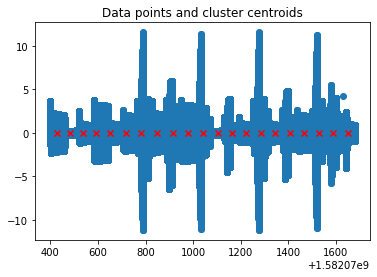

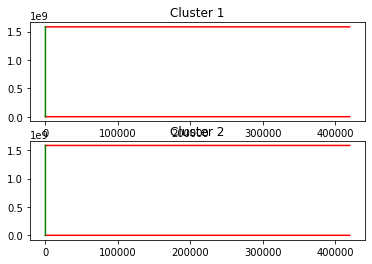

In [5]:
import operator
import numpy as np
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
import pandas as pd
from sklearn.cluster import KMeans
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

ip_addr = "sensorweb.us"
user_name = "test"
user_pwd = "sensorweb"
db_name = "waveform"

client = InfluxDBClient(host=ip_addr, port=8086, username=user_name, password=user_pwd, database=db_name, ssl=True)

tag_list = ["attack_01", "attack_07", "attack_08"]

# influxdb query data command
measurement = "sensor_04"
field_key = "Ib"
tag_key = "case"
tag_value = "attack_05"
start_time = "" 
end_time = ""

#query_command = 'SELECT * FROM "' + measurement + \
 #         '"'
#for tag_value in tag_list:
query_command = 'SELECT "'+ field_key + '"::field,"' + tag_key +'"::tag FROM "' + measurement + \
          '"'# WHERE ("'+ tag_key +'" = \''+tag_value+'\') '


query_result = client.query(query_command)


# points is a list of dictionary
points = list(query_result.get_points())

values =  map(operator.itemgetter(field_key), points)
data1 = list(values)
test =  map(operator.itemgetter(tag_key), points)
labels = list(test)
#print(np.unique(labels))
#print(data.shape)

if(len(data1) == 0):
  print("No data in the chosen time range!")
  quit()
else:
  print("len:", len(data1))

times  =  map(operator.itemgetter('time'),  points)
time = list(times)
time1=[]
cases=[]
for t in time:
    time1.append(str(t))
for l in labels:
    cases.append(l)

#print(time1[0:5])

length = int(len(data1)) # print(np.unique(y))


timet = []
i=0
while i < length:
      #print (t)
      if len(time[i])==27:
        temp = datetime.strptime(time[i], "%Y-%m-%dT%H:%M:%S.%fZ")
      elif len(time[i])==20:
        temp = datetime.strptime(time[i], "%Y-%m-%dT%H:%M:%SZ")
      timet.append(temp)
      i+=1


datatemp={'time':[x for x in time1],
      'data':[d for d in data1],
      'case':[c for c in cases]}
dataset=pd.DataFrame(datatemp,columns=['time','data','case'])
fs = 20000 # for electric waveform data, 20KHz
dataset.case = pd.Categorical(dataset.case)
dataset['label'] = dataset.case.cat.codes
#dataset.drop(['case'], axis=1)
del dataset['case']

#print(dataset[90000:90005])


X=np.zeros((length,2),dtype=np.float64)

y=[] #np.zeros((length,1),dtype=np.float64)

i=0
while i<length:
  X[i][0]= int(timet[i].timestamp())
  X[i][1]= dataset['data'][i]
  y.append(dataset['label'][i])
  i+=1

del dataset

# Specify the number of clusters and fit the data X
#print(len(np.unique(y)))
ks = KMeans(n_clusters=len(np.unique(y)), random_state=0)
kmeans = ks.fit(X) #KMeans(n_clusters=2, random_state=0).fit(X)
# Get the cluster centroids
print("CLuster centers")
print(ks.cluster_centers_)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(X[:, 0], X[:, -1])
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
    
plt.title('Data points and cluster centroids')
plt.show()
for yi in range(2):
        plt.subplot(2, 1, 1 + yi)
        for xx in X[kmeans == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(X, color='red')
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-", color='green')
        #plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))
#a=[[-1.0, -4.6],[12.2, 80.0],[5.5,7.0]]
#print([[1.0, 4.6]])
#print("Predictions:")
#kmeans.predict(a)